# C-HMC vs HUG on Ellipse with $\mathcal{N}(0, \mathrm{I})$ prior and Epanochnikov kernel

### C-HMC: Exact Manifold Sampling
Constraint function: $f(\xi) = \log \mathcal{N}(\xi\mid \mu, \Sigma)$

Jacobian constraint: $J_f(\xi) = (- \Sigma^{-1}(\xi - \mu))^\top$

Prior distribution: $p(\xi) = \mathcal{N}(\xi\mid 0, \mathrm{I})$

Target Density (Density on Manifold): $\log\pi(\xi) = \log p(\xi) - \log \| \Sigma^{-1}(\xi - \mu)\|$

Grad Density on Manifold: 

$$
\log \pi(\xi) = \nabla_\xi \log p(\xi) - \frac{1}{\|\Sigma^{-1}(\xi-\mu)\|^2} \Sigma^{-\top}\Sigma^{-1} (\xi - \mu)
$$

### HUG: Approximate Manifold Sampling
Target Density (Filamentary):  $\log \pi(\xi) = \log p(\xi) + \log k_\epsilon(\|f(\xi) - y^*\|)$

### Number of Jacobian Computations

- HUG: $BN$
- THUG: $1 + (B+1)N$

In [69]:
import numpy as np
from numpy.linalg import norm, solve, det
from numpy.random import default_rng
from numpy import log, exp, zeros, eye, pi, array, diag
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as plt

from mici.samplers import ChainState
from mici.systems import DenseConstrainedEuclideanMetricSystem as DCEMS
from mici.integrators import ConstrainedLeapfrogIntegrator as CLI
from mici.samplers import DynamicMultinomialHMC as DMHMC
from mici.samplers import StaticMetropolisHMC as SMHMC

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from tangential_hug_functions import Hug, HugTangential
from utils import ESS_univariate, prep_contour

In [83]:
# Manifold
μ       = zeros(2)
Σ       = diag([1.0, 5.0])
target  = MVN(μ, Σ)
z0      = -2.9513586307684885                # Specifies exactly which ellipse we are interested in (y*).
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

In [84]:
HMC_STATIC   = True  # Use Standard HMC or DynamicMultinomial (i.e. Stan's Default)
HMC_ADAPTIVE = False   # Use fixed step size or adaptively

# Settings
N_CHMC = 1000  # Number of samples for C-HMC
δ_CHMC = 0.5   # Step-size for C-HMC
n_CHMC = 5     # Number of integrator steps to simulate in each transition 
T_CHMC = δ_CHMC * n_CHMC

ϵ_HUG = 0.001
N_HUG = 1000
T_HUG = T_CHMC
B_HUG = n_CHMC

ϵ_THUG = ϵ_HUG
N_THUG = N_HUG
T_THUG = T_HUG
B_THUG = B_HUG

In [85]:
### Functions for C-HMC
logprior      = lambda xi: MVN(zeros(2), eye(2)).logpdf(xi)
grad_logprior = lambda xi: -xi
constr        = lambda q: array([target.logpdf(q) - z0])
jacob_constr  = lambda q: (- solve(Σ, q - μ)).reshape(1, -1)
neg_log_dens  = lambda q: -log(norm(solve(Σ, q - μ))) + logprior(q)

def grad_neg_log_density(q):
    sol = solve(Σ, q - μ)
    return grad_logprior(q) - solve(Σ.T, sol) / norm(sol)**2

def trace_func(state):
    x, y = state.pos
    return {'x': x, 'y': y}


#### Functions for HUG
q = MVN(zeros(2), eye(2))

def log_epanechnikov_kernel(xi, epsilon, ystar):
    u = norm(target.logpdf(xi) - ystar)
    with np.errstate(divide='ignore'):
        return log((3*(1 - (u**2 / (epsilon**2))) / (4*epsilon)) * float(u <= epsilon))

logpi_HUG = lambda xi: logprior(xi) + log_epanechnikov_kernel(xi, ϵ_HUG, z0)
grad_HUG  = lambda xi: -solve(Σ, xi - μ)


### Functions for THUG
logpi_THUG = lambda xi: logprior(xi) + log_epanechnikov_kernel(xi, ϵ_THUG, z0)
grad_THUG  = lambda xi: -solve(Σ, xi - μ)

### C-HMC

In [86]:
system         = DCEMS(neg_log_dens, constr, jacob_constr=jacob_constr, grad_neg_log_dens=grad_neg_log_density)

if not HMC_ADAPTIVE:
    integrator = CLI(system, step_size=δ_CHMC)
else:
    integrator = CLI(system)
    
if HMC_STATIC:
    print("Using StaticMetropolisHMC")
    sampler    = SMHMC(system, integrator, default_rng(seed=1234), n_step=n_CHMC)
else:
    print("Using DynamicMultinomialHMC")
    sampler    = DMHMC(system, integrator, default_rng(seed=1234))

init_state = ellipse.sample()
init_state_CHMC = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
if not HMC_ADAPTIVE:
    print("Sampling with fixed step size.")
    final_state, trace, stat = sampler.sample_chain(n_iter=N_CHMC, init_state=init_state_CHMC, trace_funcs=[trace_func])
else:
    print("Sampling with adaptive step size.")
    n_warm_up_iter = N_CHMC // 5
    n_main_iter = N_CHMC - n_warm_up_iter
    sampler.sample_chains_with_adaptive_warm_up(n_warm_up_iter=n_warm_up_iter, n_main_iter=n_main_iter, init_states=[init_state_CHMC], trace_funcs=[trace_func])

Using StaticMetropolisHMC
Sampling with fixed step size.


Chain 1/1: 100%|██████████|1000/1000 [00:02<00:00, 405.07it/s, accept_stat=0.581]

### HUG

In [87]:
hug_samples, acceptance_hug = Hug(init_state, T_HUG, B_HUG, N_HUG, q, logpi_HUG, grad_HUG)

### THUG

In [88]:
thug_samples, acceptance_thug = HugTangential(init_state, T_THUG, B_THUG, N_THUG, 0.99, q, logpi_THUG, grad_THUG)

# Comparisons

In [89]:
rmse = lambda x: np.sqrt(np.mean(x**2))


### Computations for CHMC
CHMC_stats           = {key[0].split('.', 1)[1]: value for (key, value) in final_state._call_counts.items()}
n_constr_eval_CHMC   = CHMC_stats['constr']
n_jac_constr_CHMC    = CHMC_stats['jacob_constr']
n_grad_log_dens_CHMC = CHMC_stats['grad_neg_log_dens']
samples_CHMC         = np.vstack((trace['x'], trace['y'])).T
dens_values_CHMC     = np.exp(-np.apply_along_axis(neg_log_dens, 1, samples_CHMC))
logpiESS_CHMC        = ESS_univariate(dens_values_CHMC)
constr_per_ess_chmc  = n_constr_eval_CHMC / logpiESS_CHMC
c_and_j_per_ess_chmc = (n_constr_eval_CHMC + n_jac_constr_CHMC) / logpiESS_CHMC
rmse_CHMC            = rmse(np.apply_along_axis(lambda xi: target.logpdf(xi), 1, samples_CHMC) - z0)


### Computations for HUG
dens_values_HUG     = np.exp(np.apply_along_axis(logpi_HUG, 1, hug_samples))
logpiESS_HUG        = ESS_univariate(dens_values_HUG)
n_constr_eval_HUG   = N_HUG + 1
n_jacob_constr_HUG  = B_HUG * N_HUG
eval_per_ess_hug    = n_constr_eval_HUG / logpiESS_HUG
c_and_j_per_ess_hug = (n_constr_eval_HUG + n_jacob_constr_HUG) / logpiESS_HUG
rmse_HUG            = rmse(np.apply_along_axis(lambda xi: target.logpdf(xi), 1, hug_samples) - z0)


### Computations for THUG
dens_values_THUG     = np.exp(np.apply_along_axis(logpi_THUG, 1, thug_samples))
logpiESS_THUG        = ESS_univariate(dens_values_THUG)
n_constr_eval_THUG   = N_THUG + 1
n_jacob_constr_THUG  = 1 + (B_THUG + 1) * N_THUG
eval_per_ess_thug    = n_constr_eval_THUG / logpiESS_THUG
c_and_j_per_ess_thug = (n_constr_eval_THUG + n_jacob_constr_THUG) / logpiESS_THUG
rmse_THUG            = rmse(np.apply_along_axis(lambda xi: target.logpdf(xi), 1, thug_samples) - z0)

### Plotting

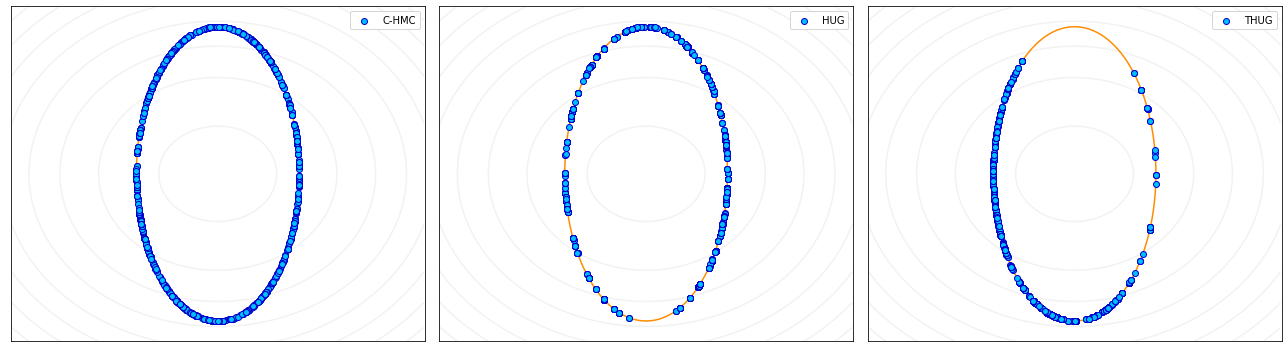

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
### C-HMC
ax[0].contour(*prep_contour([-2, 2], [-2, 2], 0.01, logprior), zorder=-1, colors='gray', linestyles='solid', alpha=0.1)
ax[0].contour(*prep_contour([-2, 2], [-2, 2], 0.01, target.logpdf), levels=[z0], colors='darkorange', linestyles='solid', zorder=0)
ax[0].scatter(*samples_CHMC.T, label='C-HMC', color='deepskyblue', edgecolor='mediumblue')
ax[0].legend()
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-2, 2])
ax[0].set_xticks([])
ax[0].set_yticks([])
### HUG
ax[1].contour(*prep_contour([-2, 2], [-2, 2], 0.01, logprior), zorder=-1, colors='gray', linestyles='solid', alpha=0.1)
ax[1].contour(*prep_contour([-2, 2], [-2, 2], 0.01, target.logpdf), levels=[z0], colors='darkorange', linestyles='solid', zorder=0)
ax[1].scatter(*hug_samples.T, label='HUG', color='deepskyblue', edgecolor='mediumblue')
ax[1].legend()
ax[1].set_xlim([-2, 2])
ax[1].set_ylim([-2, 2])
ax[1].set_xticks([])
ax[1].set_yticks([])
### THUG
ax[2].contour(*prep_contour([-2, 2], [-2, 2], 0.01, logprior), zorder=-1, colors='gray', linestyles='solid', alpha=0.1)
ax[2].contour(*prep_contour([-2, 2], [-2, 2], 0.01, target.logpdf), levels=[z0], colors='darkorange', linestyles='solid', zorder=0)
ax[2].scatter(*thug_samples.T, label='THUG', color='deepskyblue', edgecolor='mediumblue')
ax[2].legend()
ax[2].set_xlim([-2, 2])
ax[2].set_ylim([-2, 2])
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.tight_layout()
plt.show()

### Acceptance Probability

In [92]:
print("Mean Acceptance Probability HUG:  {:.3}".format(acceptance_hug.mean() * 100))
print("Mean Acceptance Probability THUG: {:.3}".format(acceptance_thug.mean() * 100))
print("Mean Acceptance Probability CHMC: {:.3}".format(stat['accept_stat'].mean() * 100))

Mean Acceptance Probability HUG:  16.5
Mean Acceptance Probability THUG: 28.7
Mean Acceptance Probability CHMC: 58.1


### Constraint Evaluations

In [93]:
print("HUG:  ", n_constr_eval_HUG)
print("THUG: ", n_constr_eval_THUG)
print("CHMC: ", n_constr_eval_CHMC)

HUG:   1001
THUG:  1001
CHMC:  76959


### Jacobian Constraint

In [94]:
print("HUG:  ", n_jacob_constr_HUG)
print("THUG: ", n_jacob_constr_THUG)
print("CHMC: ", n_jac_constr_CHMC)

HUG:   5000
THUG:  6001
CHMC:  3639


### Constraint + Jacobian

In [95]:
print("HUG:  ", n_constr_eval_HUG + n_jacob_constr_HUG)
print("THUG: ", n_constr_eval_THUG + n_jacob_constr_THUG)
print("CHMC: ", n_constr_eval_CHMC + n_jac_constr_CHMC)

HUG:   6001
THUG:  7002
CHMC:  80598


### Evaluations per ESS

In [96]:
print("--- Constraint ---")
print("HUG:  ", n_constr_eval_HUG / logpiESS_HUG)
print("THUG: ", n_constr_eval_THUG / logpiESS_THUG)
print("CHMC: ", n_constr_eval_CHMC / logpiESS_CHMC)

print("\n")

print("--- Constraint + Jacobian ---")
print("HUG:  ", (n_constr_eval_HUG + n_jacob_constr_HUG) / logpiESS_HUG)
print("THUG: ", (n_constr_eval_THUG + n_jacob_constr_THUG) / logpiESS_THUG)
print("CHMC: ", (n_constr_eval_CHMC + n_jac_constr_CHMC) / logpiESS_CHMC)

print("\n")

print("--- Constraint + Jacobian + Grad Log Density ---")
print("HUG:  ", (n_constr_eval_HUG + n_jacob_constr_HUG) / logpiESS_HUG)
print("THUG: ", (n_constr_eval_THUG + n_jacob_constr_THUG) / logpiESS_THUG)
print("CHMC: ", (n_constr_eval_CHMC + n_jac_constr_CHMC + n_grad_log_dens_CHMC) / logpiESS_CHMC)

--- Constraint ---
HUG:   24.13540476593839
THUG:  77.91674212704034
CHMC:  386.505185505721


--- Constraint + Jacobian ---
HUG:   144.691872128268
THUG:  545.0280003731632
CHMC:  404.78105148702684


--- Constraint + Jacobian + Grad Log Density ---
HUG:   144.691872128268
THUG:  545.0280003731632
CHMC:  423.0569174683327
